# AB Testing On Landing Page Data

We will try to analyse which landing page version is more popular from the data gathered.

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from IPython.display import display
sns.set_palette("pastel")
plt.rcParams["figure.figsize"] = (20, 9)

### Load dataset

In [56]:
df = pd.read_csv('data/ab_data.csv')

### Display the usual data about this dataset

In [57]:
display(df.head())

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [58]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


None

In [59]:
display(df.columns)

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [60]:
display(df.nunique())

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [61]:
display(df.describe())

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


#### Check for null values

In [62]:
assert df.isnull().values.sum() == 0, 'error null values'
display('no null value')

'no null value'

# Clean up data and remove duplcates

In [63]:
display(df.query('group == "treatment"').shape[0])
display(df.query('landing_page == "new_page"').shape[0])

147276

147239

#### Drop rows that do not have the correct data

In [64]:
false_index = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index
display(false_index.shape[0])
df2 = df.drop(false_index)

3893

In [65]:
display(df2.query('group == "treatment"').shape[0])
display(df2.query('landing_page == "new_page"').shape[0])
assert df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0] == 0

145311

145311

#### Total unique users

In [66]:
display(df2['user_id'].nunique())

290584

#### Check duplicated users

In [67]:
dup_u = df2[df2.duplicated(['user_id'], keep=False)]
print(dup_u)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


#### Drop the first duplicate user

In [68]:
df2.drop(dup_u.index[0], inplace=True)
dup_u = df2[df2.duplicated(['user_id'], keep=False)]
assert len(dup_u) == 0

#### Overall conversion rate

In [69]:
p_overall = len(df2.query('converted == 1')) / len(df2)
display(p_overall)

0.11959708724499628

#### Control Group Conversion Rate

In [70]:
p_control = len(df2.query('group == "control" & converted == 1')) / len(df2.query('group == "control"'))
display(p_control)

0.1203863045004612

#### Treatment Group Conversion Rate

In [71]:
p_treat = len(df2.query('group == "treatment" & converted == 1')) / len(df2.query('group == "treatment"'))
display(p_treat)

0.11880806551510564

#### The probability of landing on the new page

In [72]:
p_new = len(df2.query('landing_page == "new_page"')) / len(df2)
display(p_new)

0.5000619442226688

## A/B Testing

We need to do A/B testing by comparing two independent population proportions

#### Hypothesis<br>
* H0: p_old = p_new<br>
* H1: p_new - p_old > 0

At 5% significance level the test statistics would have to larger than critical value of

In [73]:
critical_val = stats.norm.ppf(1-(0.05/2))
print(critical_val)

1.959963984540054


#### Method 1 - by calculation

In [74]:
n_old = df2.query('group == "control"').shape[0]
n_old_converted = df2.query('group == "control" & converted == 1').shape[0]
n_new = df2.query('group == "treatment"').shape[0]
n_new_converted = df2.query('group == "treatment" & converted == 1').shape[0]
print(n_old)
print(n_new)
print(n_old_converted)
print(n_new_converted)

145274
145310
17489
17264


In [75]:
p_c = (n_old_converted + n_new_converted) / (n_old + n_new)
print(p_c)

0.11959708724499628


In [76]:
p_old = n_old_converted / n_old
p_new = n_new_converted / n_new

In [77]:
test_stat = (p_new - p_old) / np.sqrt(p_c * (1-p_c) * (1/n_old+1/n_new))
print(test_stat)

-1.3109241984234394


In [78]:
p_value = stats.norm.sf(test_stat)
print(p_value)

0.9050583127590245


### Method 2 - by statistical package

In [79]:
z_score, p_value = sm.stats.proportions_ztest([n_new_converted, n_old_converted], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


### Method 3 - by sampling under the null hypothsis

conversion rate under the null hypothesis

In [80]:
p_null = len(df2.query('converted == 1')) / len(df2)
p_old = p_null
p_new = p_null
p_diffs = list()
for i in range(0, 10000):
    n_old_converted = np.random.choice([1, 0], size=n_new, replace=True, p=(p_old, 1-p_old))
    n_new_converted = np.random.choice([1, 0], size=n_new, replace=True, p=(p_new, 1-p_new))
    p_diffs.append(n_new_converted.mean() - n_old_converted.mean())

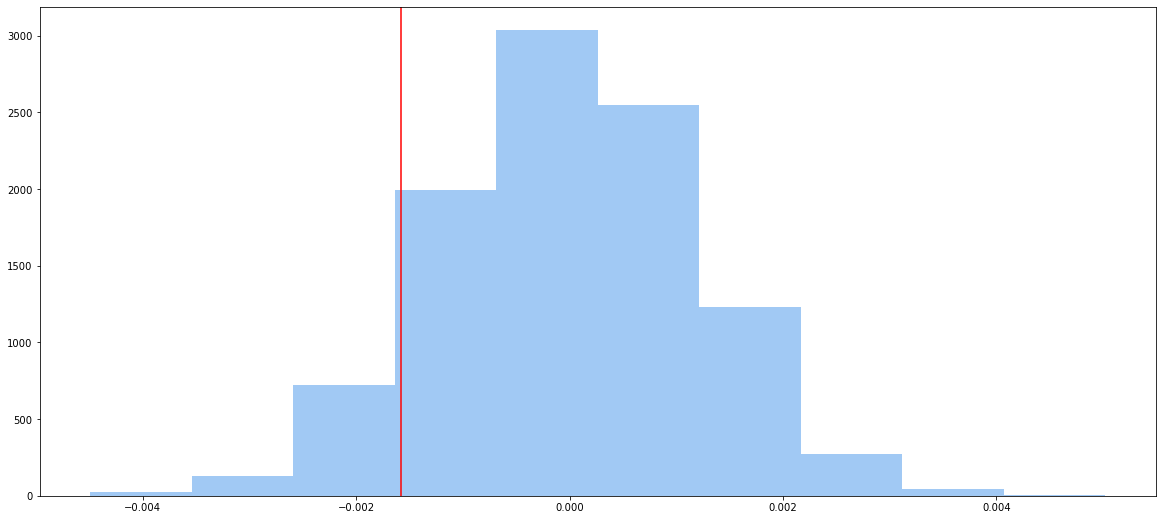

0.908


In [81]:
observed_diff = p_treat - p_control
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(observed_diff, color='r')
plt.show()
p_value = (p_diffs > observed_diff).mean()
print(p_value)

* test statistics is lower than critical value<br>
* p value is larger than 0.05<br>
* There is not enough evidence to reject the null hypothesis